In [1]:
import numpy as np
import random as rd
import math

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

%load_ext autoreload
%autoreload 2

In [2]:
num_agents = 10
seed = 42

T = 500
mu = 0.05

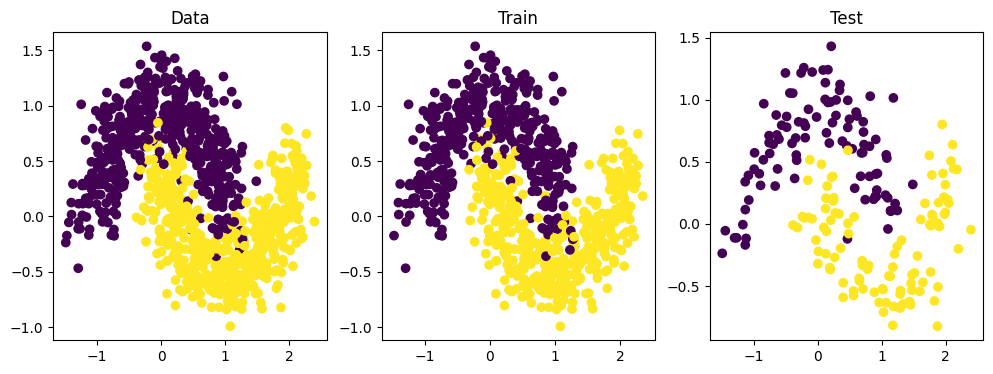

In [3]:
X, Y = make_moons(n_samples=1000, noise=0.2)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=0.2)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

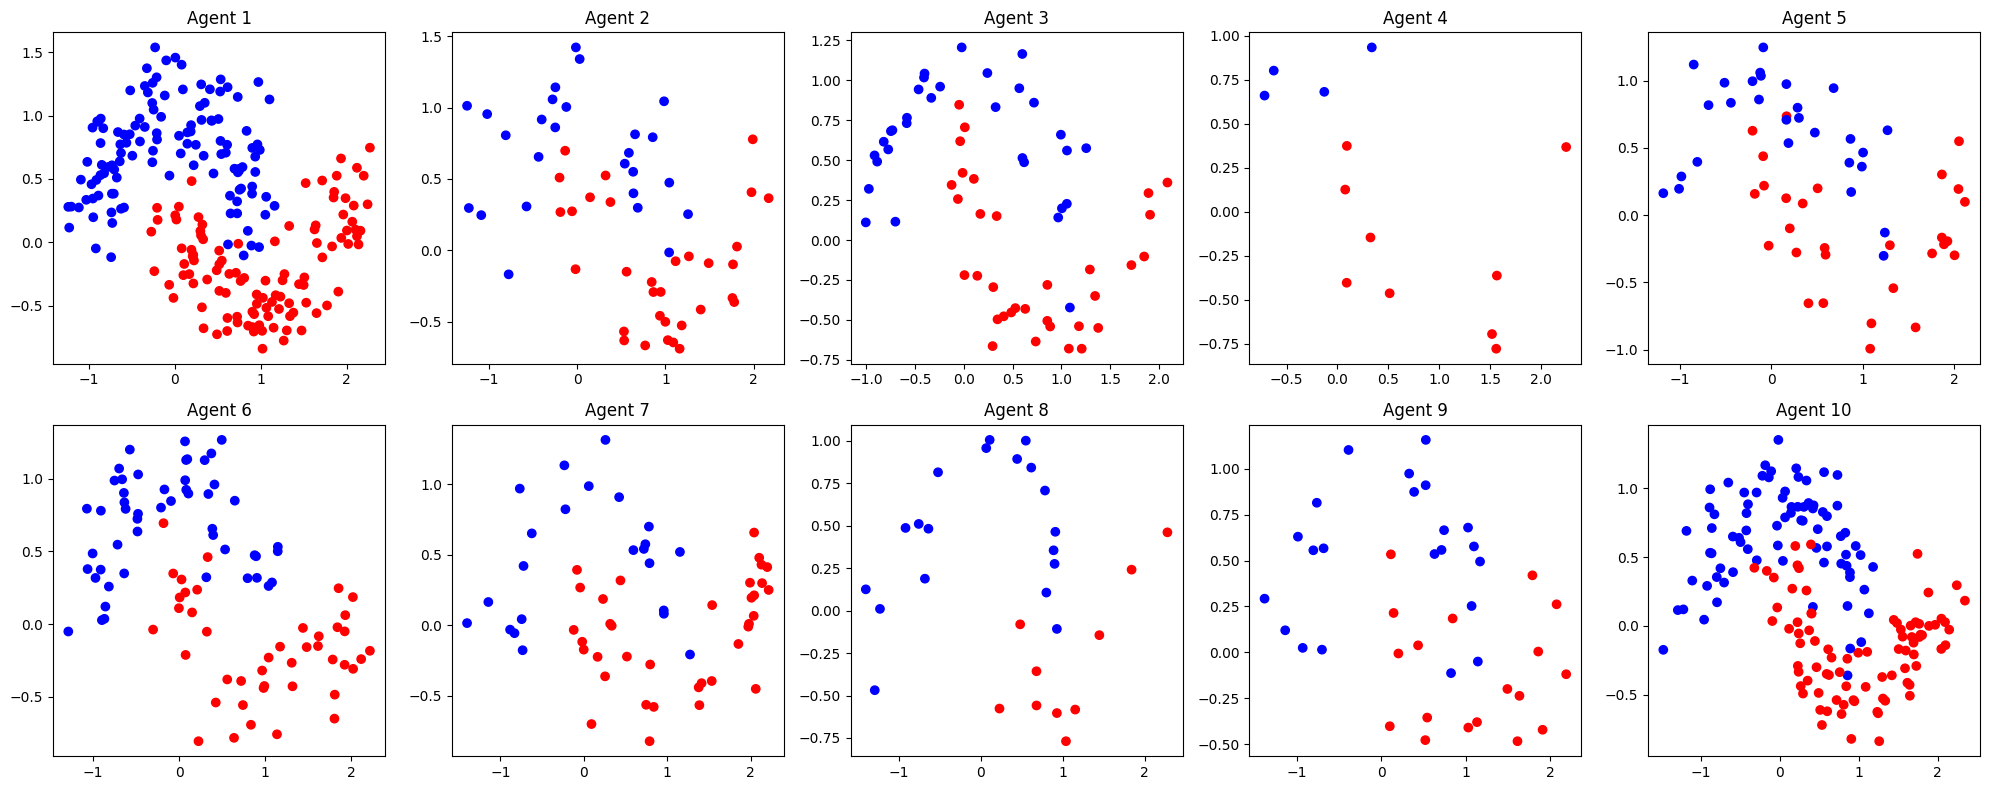

In [4]:

X_agent, Y_agent = ml.split_into_random_subsets(X_train, Y_train, random_state=seed)
#X_agent, Y_agent = ml.split_horizontally(X_train, Y_train)


fig, axes = plt.subplots(nrows=2, ncols=int(num_agents/2), figsize=(20, 8))

for i in range(num_agents):
    row = i // (num_agents // 2)
    col = i % (num_agents // 2)
    colors = ['blue' if y== 0 else 'red' for y in Y_agent[i]]
    axes[row, col].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[row, col].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [5]:
X_agent_augmented = []
for i in range(num_agents):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4, X_agent[i]**5], axis=1))

In [6]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4, X_test**5], axis=1)
X_train_augmented = np.concatenate([X_train, X_train**2, X_train**3, X_train**4, X_train**5], axis=1)

In [7]:
G = np.zeros((num_agents, num_agents))
for i in range(num_agents):
    for j in range(num_agents):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(num_agents)
c = np.zeros(num_agents)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(num_agents):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize

print(f"G: {G}")
print(f"D: {D}")
print(f"c: {c}")

Max: 225
Min: 13
Mean: 80.0
G: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
D: [1. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
c: [1.         0.25777778 0.28444444 0.05777778 0.25333333 0.41777778
 0.26222222 0.12888889 0.17777778 0.71555556]


## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf

Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $


## Training

### Single Global Model

In [8]:
np.random.seed(seed)
thetas_mono = np.random.rand(X_train_augmented.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

for i in range(T):
    thetas_mono = ml.stepForwardMono(thetas_mono, X_train_augmented, Y_train)
    costs_train_mono[i] = lr.cost(thetas_mono, X_train_augmented, Y_train)
    costs_test_mono[i] = lr.cost(thetas_mono, X_test_augmented, Y_test)
    if i % (T/10) == 0:
                print(f'Iteration {i} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

# np.random.seed(seed)
# thetas_agents_globalModel = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

# costs_train_agents_globalModel = np.zeros((T, num_agents))
# costs_test_agents_globalModel = np.zeros((T, num_agents))

# print(T)
# for i in range(T):
#     thetas_agents_globalModel = ml.stepForward(thetas_agents_globalModel, X_agent_augmented, Y_agent, num_agents, 0, c, G, D)
#     for j in range(num_agents):
#             costs_train_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_agent_augmented[j], Y_agent[j])
#             costs_test_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_test_augmented, Y_test)
#     if i % 1000 == 0 :
#         print(f'Iteration {i+1} : Train: {np.mean(costs_train_agents_globalModel[i]):.4f} and {np.std(costs_train_agents_globalModel[i]):.4f} | Test: {np.mean(costs_test_agents_globalModel[i]):.4f} and {np.std(costs_test_agents_globalModel[i]):.4f}')

Iteration 0 : Train: 1.3926 | Test: 1.3362
Iteration 50 : Train: 1.0164 | Test: 0.9898
Iteration 100 : Train: 0.7142 | Test: 0.7126
Iteration 150 : Train: 0.5392 | Test: 0.5485
Iteration 200 : Train: 0.4616 | Test: 0.4715
Iteration 250 : Train: 0.4205 | Test: 0.4295
Iteration 300 : Train: 0.3941 | Test: 0.4027
Iteration 350 : Train: 0.3752 | Test: 0.3835
Iteration 400 : Train: 0.3607 | Test: 0.3688
Iteration 450 : Train: 0.3491 | Test: 0.3570


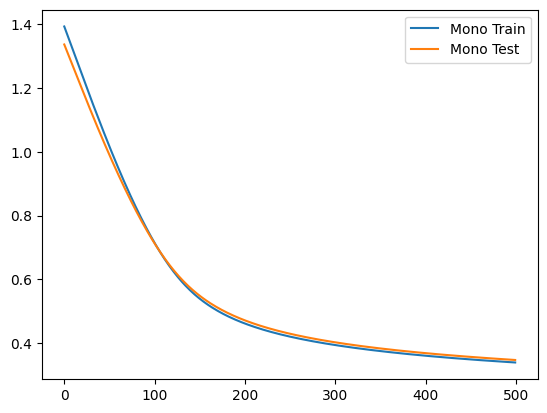

In [9]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

# util.plot_curves(num_agents, costs_train_agents_globalModel, costs_test_agents_globalModel, "Multiple Agents")

### Multiple agents

Agents dont share their models (perfectly private baseline)

In [10]:
np.random.seed(seed)
thetas_agents_alone = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents_alone = np.zeros((T, num_agents))
costs_test_agents_alone = np.zeros((T, num_agents))
costs_train_alone = np.zeros(T)
costs_test_alone = np.zeros(T)

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents_alone = ml.stepForwardAlone(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_test_augmented, Y_test)
    costs_train_alone[i] = lr.costDecentralized(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_alone[i] = lr.costDecentralized(thetas_agents_alone, X_test_augmented, Y_test, num_agents, G, D, c, mu)

    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents_alone[i]):.4f} , {np.mean(costs_test_agents_alone[i]):.4f}) | ({costs_train_alone[i]:.4f} , {costs_test_alone[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.1428 , 1.1738) | (8.3247 , 8.0181)
 50 : (0.7999 , 0.8633) | (9.2332 , 9.0227)
100 : (0.6080 , 0.6846) | (10.3743 , 10.2203)
150 : (0.5163 , 0.5912) | (11.1045 , 10.9747)
200 : (0.4652 , 0.5357) | (11.5008 , 11.3837)
250 : (0.4320 , 0.4977) | (11.6912 , 11.5822)
300 : (0.4076 , 0.4688) | (11.7831 , 11.6798)
350 : (0.3885 , 0.4459) | (11.8266 , 11.7279)
400 : (0.3729 , 0.4271) | (11.8473 , 11.7522)
450 : (0.3599 , 0.4114) | (11.8617 , 11.7696)


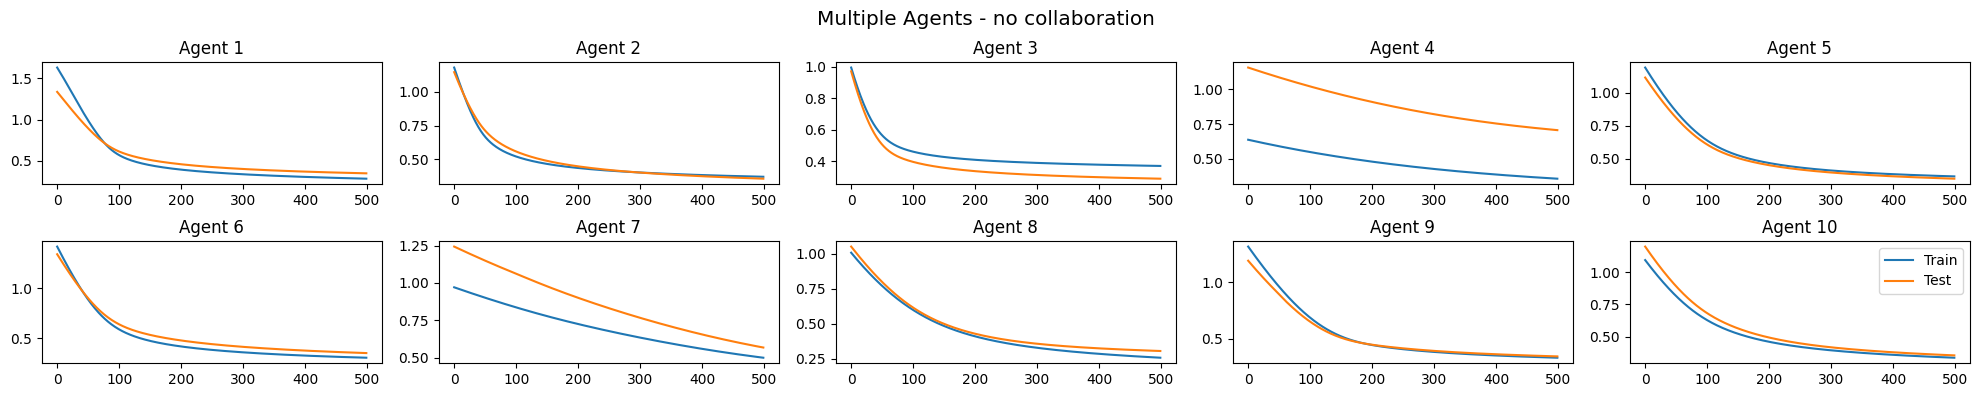

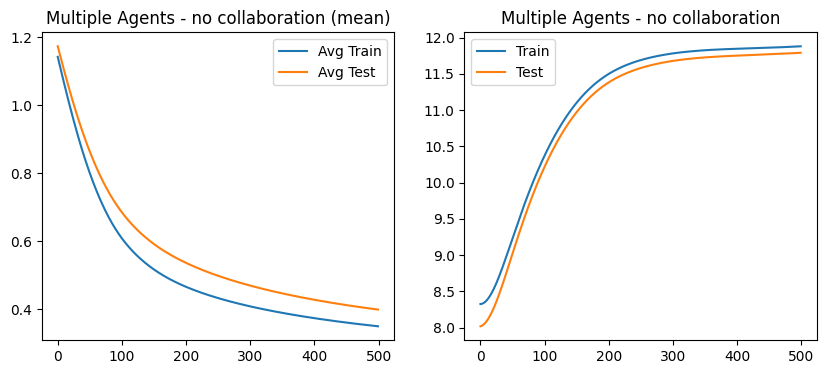

In [11]:
util.plot_curves(num_agents, costs_train_agents_alone, costs_test_agents_alone, costs_train_alone, costs_test_alone, "Multiple Agents - no collaboration")

### Multiple agents

All agents do a step after each other in a naive queue and share their models

In [12]:
np.random.seed(seed)
thetas_agents = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents = np.zeros((T, num_agents))
costs_test_agents = np.zeros((T, num_agents))
costs_train = np.zeros(T)
costs_test = np.zeros(T)

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)
    costs_train[i] = lr.costDecentralized(thetas_agents, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test[i] = lr.costDecentralized(thetas_agents, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents[i]):.4f} , {np.mean(costs_test_agents[i]):.4f}) | ({costs_train[i]:.4f} , {costs_test[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.1450 , 1.1730) | (7.1657 , 6.8589)
 50 : (0.8357 , 0.8650) | (1.0645 , 0.8473)
100 : (0.6340 , 0.6582) | (0.7016 , 0.5409)
150 : (0.5322 , 0.5448) | (0.5263 , 0.3919)
200 : (0.4729 , 0.4784) | (0.4004 , 0.2806)
250 : (0.4353 , 0.4372) | (0.3197 , 0.2092)
300 : (0.4095 , 0.4096) | (0.2687 , 0.1644)
350 : (0.3906 , 0.3896) | (0.2344 , 0.1348)
400 : (0.3758 , 0.3741) | (0.2100 , 0.1140)
450 : (0.3639 , 0.3617) | (0.1920 , 0.0989)


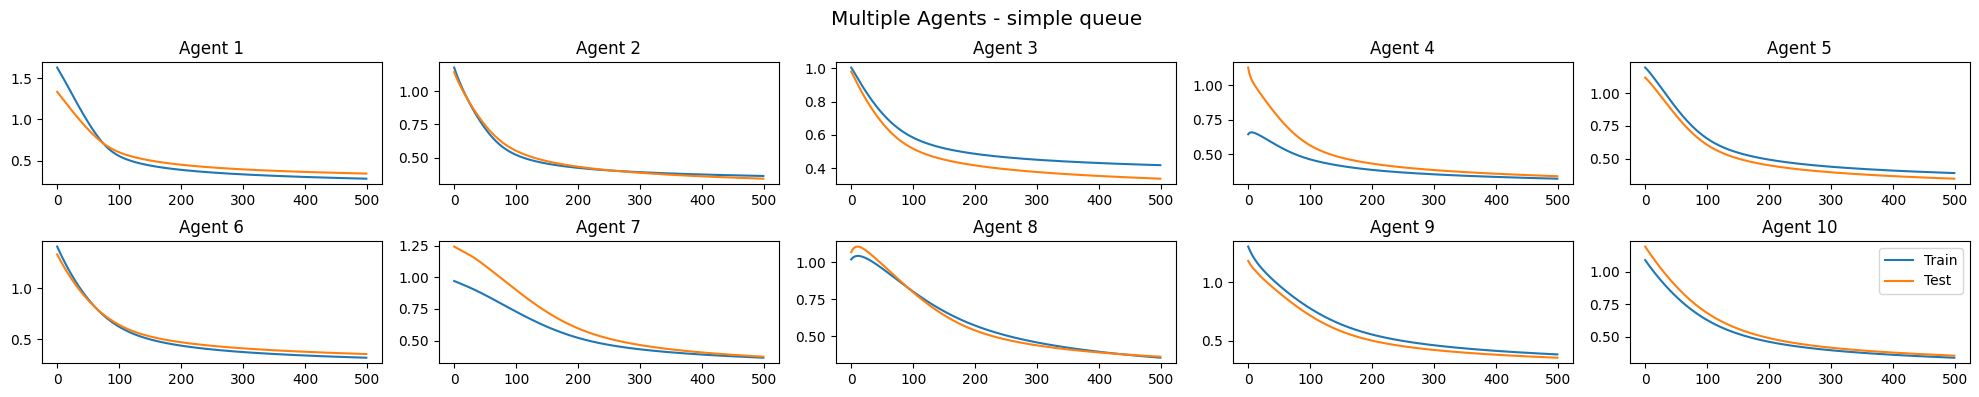

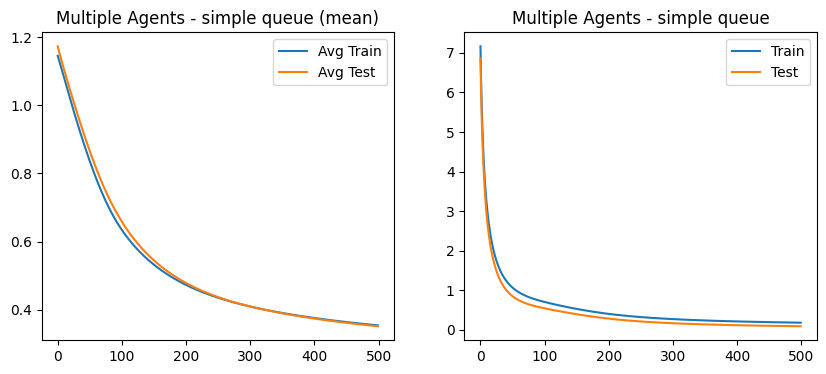

In [13]:
util.plot_curves(num_agents, costs_train_agents, costs_test_agents, costs_train, costs_test, "Multiple Agents - simple queue")

### Random drawing of Agents

randint with global quota

In [14]:
np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_rand = np.zeros((total_T, num_agents))
costs_test_rand = np.zeros(total_T)
costs_train_rand = np.zeros(total_T)


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_rand = ml.stepForward_2(thetas_agents_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_rand[i]):.4f} , {np.mean(costs_test_agents_rand[i]):.4f}) | ({costs_train_rand[int(i/10)]:.4f} , {costs_test_rand[int(i/10)]:.4f})')

costs_train_agents_rand = util.reduce_cost_matrix(costs_train_agents_rand)
costs_test_agents_rand = util.reduce_cost_matrix(costs_test_agents_rand)
costs_train_rand = costs_train_rand[:T]
costs_test_rand = costs_test_rand[:T]

Iter: Agents_Mean       | Total 
  0 : (0.1021 , 0.1069) | (7.9520 , 7.6432)
 50 : (0.0553 , 0.0765) | (1.0596 , 0.8443)
100 : (0.0703 , 0.0863) | (0.6512 , 0.4892)
150 : (0.0547 , 0.0590) | (0.4852 , 0.3497)
200 : (0.0405 , 0.0467) | (0.3717 , 0.2515)
250 : (0.0459 , 0.0505) | (0.3018 , 0.1910)
300 : (0.0440 , 0.0398) | (0.2597 , 0.1551)
350 : (0.0428 , 0.0416) | (0.2453 , 0.1452)
400 : (0.0363 , 0.0380) | (0.2213 , 0.1249)
450 : (0.0330 , 0.0350) | (0.2005 , 0.1070)


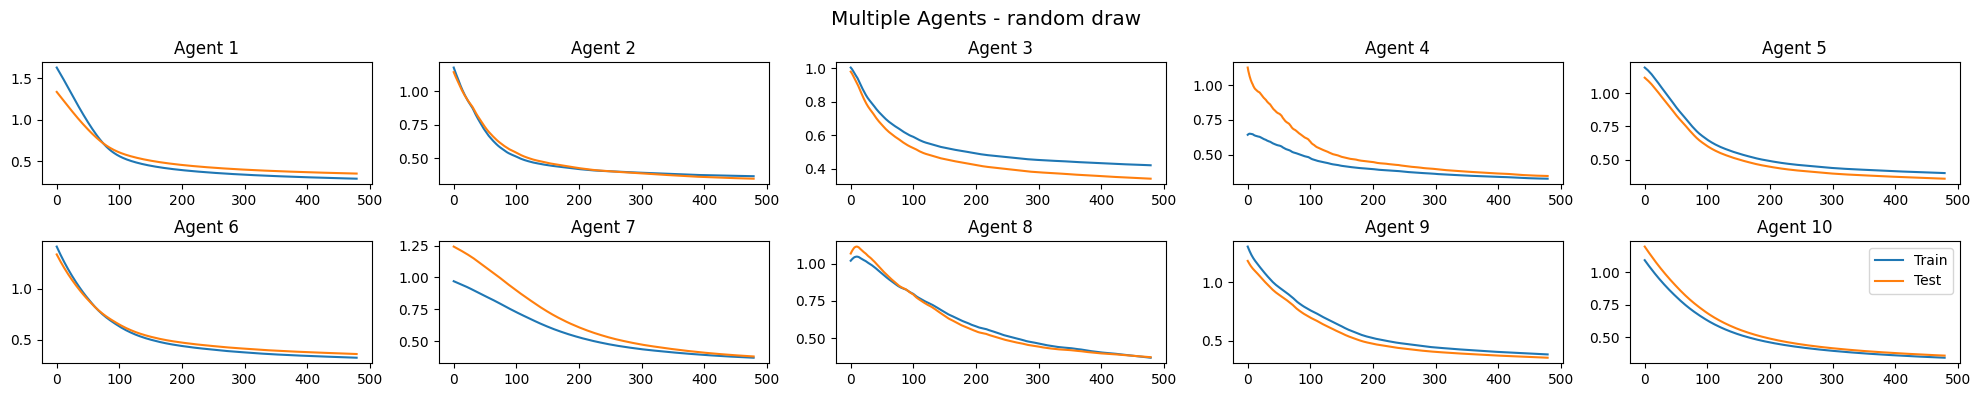

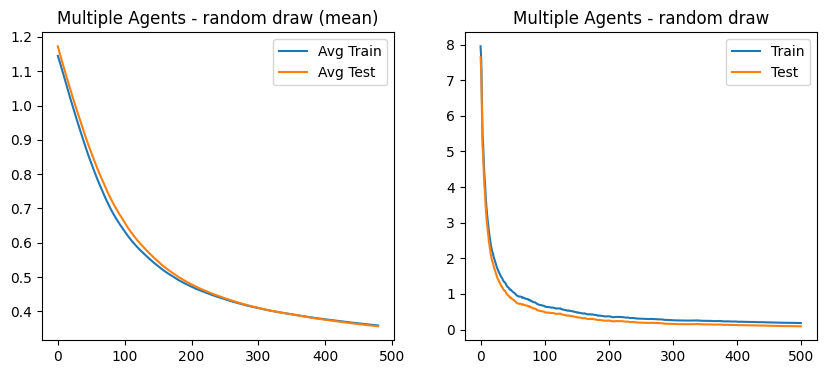

In [15]:
util.plot_curves(num_agents, costs_train_agents_rand, costs_test_agents_rand, costs_train_rand, costs_test_rand, "Multiple Agents - random draw")

### Weighting of Agents

In [16]:
np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_weigh = np.zeros((total_T, num_agents))
costs_test_weigh = np.zeros(total_T)
costs_train_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_weigh = ml.stepForward_2(thetas_agents_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_weigh[i]):.4f} , {np.mean(costs_test_agents_weigh[i]):.4f}) | ({costs_train_weigh[int(i/10)]:.4f} , {costs_test_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_weigh = costs_train_weigh[:max_non_zero]
costs_test_weigh = costs_test_weigh[:max_non_zero]


[0.28125 0.0725  0.08    0.01625 0.07125 0.1175  0.07375 0.03625 0.05
 0.20125]
Iter: Agents_Mean       | Total 
  0 : (0.1627 , 0.1334) | (8.3159 , 8.0077)
 50 : (0.0484 , 0.0545) | (1.6853 , 1.4930)
100 : (0.0362 , 0.0426) | (1.2792 , 1.1249)
150 : (0.0320 , 0.0383) | (0.9220 , 0.7906)
200 : (0.0397 , 0.0420) | (0.6931 , 0.5767)
250 : (0.0410 , 0.0443) | (0.5551 , 0.4479)
300 : (0.0265 , 0.0329) | (0.4504 , 0.3495)
350 : (0.0254 , 0.0319) | (0.4000 , 0.3039)
400 : (0.0349 , 0.0384) | (0.3759 , 0.2831)
450 : (0.0238 , 0.0305) | (0.3431 , 0.2531)


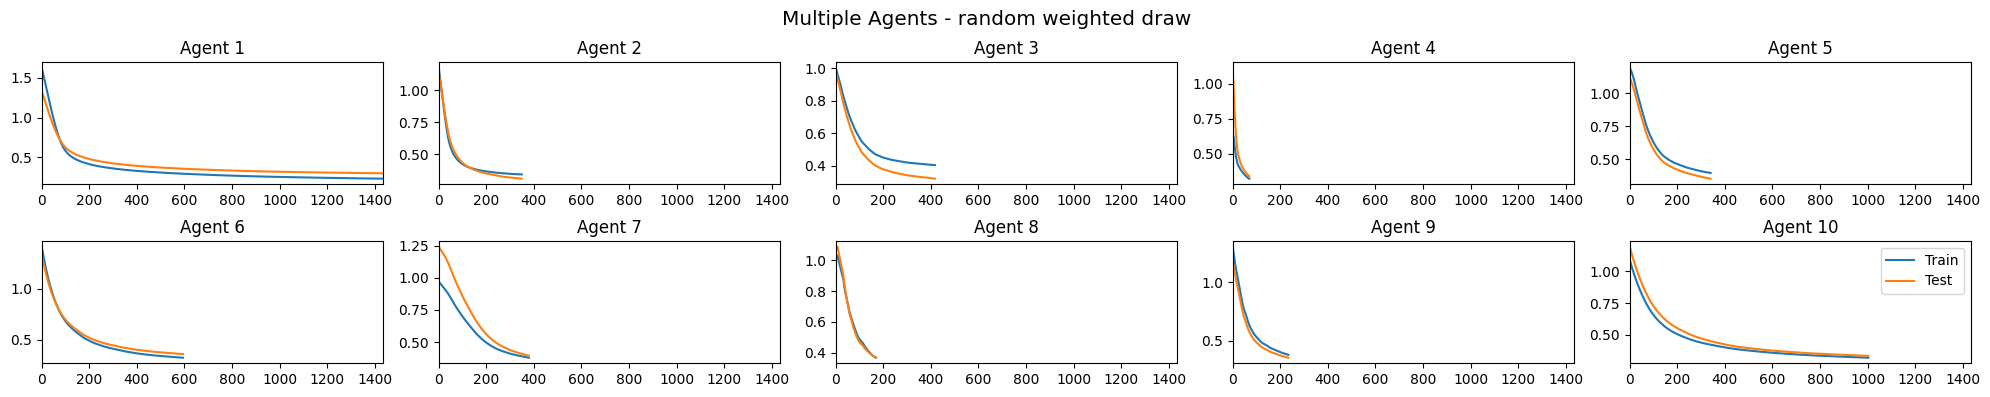

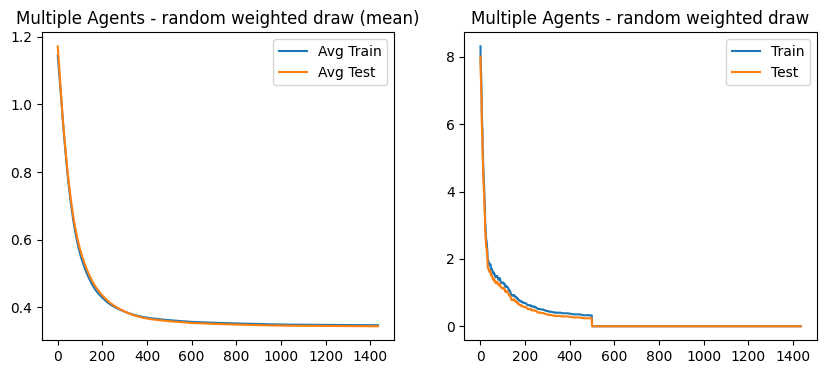

In [17]:
util.plot_curves_non_zero(num_agents, costs_train_agents_weigh_shifted, costs_test_agents_weigh_shifted, costs_train_weigh, costs_test_weigh, "Multiple Agents - random weighted draw")

## With Privacy

On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

Si on veut partir du $\bar{\epsilon}$, on va utiliser $\delta$ et $\bar{\delta}$ tous nuls, et utiliser le théorème 1 (et la proposition 2 dans un deuxième temps) pour obtenir des epsilon.

Ici on peut avoir des $\bar{\epsilon}$ très élevés


In [18]:
epsilon = 0.5 # -> ici on a donc epsilon_barre = epsilon * T = 500
L_0 = 0.25

print(type(epsilon))

np.random.seed(seed)
thetas_private = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_private = np.zeros(T)
costs_test_private = np.zeros(T)

for i in range(T):
    thetas_private = ml.stepForwardPrivate(thetas_private, X_agent_augmented, Y_agent, num_agents, mu, c, G, D, L_0, epsilon)
    costs_train_private[i] = lr.costDecentralized(thetas_private, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_private[i] = lr.costDecentralized(thetas_private, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {costs_train_private[i]:.4f} | Test: {costs_test_private[i]:.4f}')

<class 'float'>
Iteration 0 : Train: 7.2306 | Test: 6.9239
Iteration 50 : Train: 1.0782 | Test: 0.8610
Iteration 100 : Train: 0.7202 | Test: 0.5599
Iteration 150 : Train: 0.5433 | Test: 0.4090
Iteration 200 : Train: 0.4175 | Test: 0.2977
Iteration 250 : Train: 0.3385 | Test: 0.2279
Iteration 300 : Train: 0.2905 | Test: 0.1862
Iteration 350 : Train: 0.2582 | Test: 0.1585
Iteration 400 : Train: 0.2311 | Test: 0.1350
Iteration 450 : Train: 0.2118 | Test: 0.1187


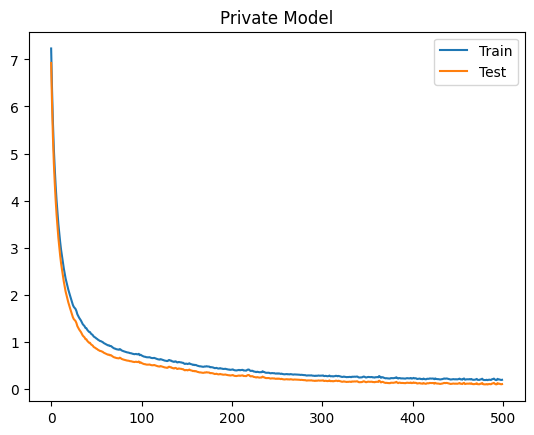

In [19]:
plt.plot(costs_train_private, label="Train")
plt.plot(costs_test_private, label="Test")
plt.title("Private Model")
plt.legend()
plt.show()

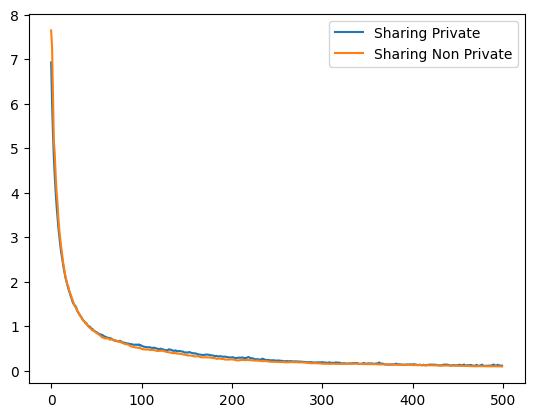

In [20]:
plt.plot(costs_test_private, label="Sharing Private")
#plt.plot(costs_test_alone, label="No Sharing")
plt.plot(costs_test_rand, label="Sharing Non Private")
plt.legend()
plt.show()

### Random drawing using constant epsilon

In [22]:

# epsilon = epsilon_barre / T # pour stepForwardPrivate normal

# il faut réestimer le epsilon_barre lorsque le nombre d'étapes d'entraînement pour un modèle n'est pas exactement T 

#epsilon_barre = 500

epsilon = 0.5
L_0 = 0.25

print(type(epsilon))

np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_private_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_rand = np.zeros((total_T, num_agents))

costs_test_private_rand = np.zeros(total_T)
costs_train_private_rand = np.zeros(total_T)


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_private_rand = ml.stepForwardPrivate_2(thetas_agents_private_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsilon) 

    costs_train_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_rand[i]):.4f} , {np.mean(costs_test_agents_private_rand[i]):.4f}) | ({costs_train_private_rand[int(i/10)]:.4f} , {costs_test_private_rand[int(i/10)]:.4f})')

costs_train_agents_private_rand = util.reduce_cost_matrix(costs_train_agents_private_rand)
costs_test_agents_private_rand = util.reduce_cost_matrix(costs_test_agents_private_rand)
costs_train_private_rand = costs_train_private_rand[:T]
costs_test_private_rand = costs_test_private_rand[:T]

<class 'float'>
Iter: Agents_Mean       | Total 
  0 : (0.1194 , 0.1117) | (8.2664 , 7.9578)
 50 : (0.0970 , 0.0907) | (1.1083 , 0.8870)
100 : (0.0787 , 0.0726) | (0.7337 , 0.5729)
150 : (0.0512 , 0.0444) | (0.6091 , 0.4734)
200 : (0.0540 , 0.0623) | (0.4585 , 0.3373)
250 : (0.0346 , 0.0407) | (0.3632 , 0.2517)
300 : (0.0440 , 0.0399) | (0.3105 , 0.2060)
350 : (0.0378 , 0.0396) | (0.2465 , 0.1469)
400 : (0.0297 , 0.0358) | (0.2571 , 0.1612)
450 : (0.0284 , 0.0346) | (0.2161 , 0.1232)


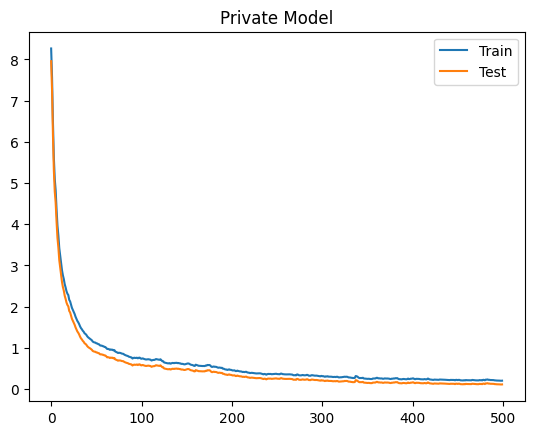

In [23]:
plt.plot(costs_train_private_rand, label="Train")
plt.plot(costs_test_private_rand, label="Test")
plt.title("Private Model")
plt.legend()
plt.show()

### Weighted drawing with constant epsilons

In [84]:

# DEFINING EPSILON_BAR
epsilon_barre = 500
L_0 = 0.25

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh = np.zeros((total_T, num_agents))

costs_test_private_weigh = np.zeros(total_T)
costs_train_private_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# des probabilités, on déduit l'espérance du nombre d'itérations pour chaque agent
nb_iterations = np.zeros(num_agents)
for i in range (num_agents):
    nb_iterations = coeffs_pond * total_T


# puis les epsilon correspondants pour chaque agent
epsilon = np.zeros(num_agents)
for i in range(num_agents): 
    epsilon[i] = epsilon_barre / nb_iterations[i]

print("Agent : Iterations  | epsilon | epsilon_barre")
for i in range(num_agents):
    print(f'{int(i):3} : ({nb_iterations[i]:.4f}) | ({epsilon[i]:.4f}) | ({epsilon[i]*nb_iterations[i]})')

print()

print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_private_weigh = ml.stepForwardPrivate_2(thetas_agents_private_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsilon[j])

    costs_train_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh[i]):.4f} , {np.mean(costs_test_agents_private_weigh[i]):.4f}) | ({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh)
costs_test_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh = costs_train_private_weigh[:T]
costs_test_private_weigh = costs_test_private_weigh[:T]


Agent : Iterations  | epsilon | epsilon_barre
  0 : (1406.2500) | (0.3556) | (500.0)
  1 : (362.5000) | (1.3793) | (500.00000000000006)
  2 : (400.0000) | (1.2500) | (500.0)
  3 : (81.2500) | (6.1538) | (500.0)
  4 : (356.2500) | (1.4035) | (500.0)
  5 : (587.5000) | (0.8511) | (500.0)
  6 : (368.7500) | (1.3559) | (500.0)
  7 : (181.2500) | (2.7586) | (500.00000000000006)
  8 : (250.0000) | (2.0000) | (500.0)
  9 : (1006.2500) | (0.4969) | (500.0)

Iter: Agents_Mean       | Total 
  0 : (0.1627 , 0.1334) | (8.3159 , 8.0077)
 50 : (0.0481 , 0.0541) | (1.4453 , 1.2536)
100 : (0.0372 , 0.0437) | (1.0261 , 0.8754)
150 : (0.0527 , 0.0460) | (0.8015 , 0.6721)
200 : (0.0297 , 0.0359) | (0.6653 , 0.5493)
250 : (0.0280 , 0.0343) | (0.5359 , 0.4290)
300 : (0.0264 , 0.0328) | (0.4764 , 0.3753)
350 : (0.0450 , 0.0435) | (0.4410 , 0.3443)
400 : (0.0407 , 0.0377) | (0.3959 , 0.3028)
450 : (0.0348 , 0.0318) | (0.3702 , 0.2799)


In [85]:
print("Iter: Total_Mean_rand   | Total_Mean_weigh")
for i in range (total_T):
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({costs_train_private_rand[int(i/10)]:.4f} , {costs_test_private_rand[int(i/10)]:.4f}) | (({costs_train_private_weigh[int(i/10)]:.4f} , {costs_test_private_weigh[int(i/10)]:.4f})')


Iter: Total_Mean_rand   | Total_Mean_weigh
  0 : (8.2664 , 7.9578) | ((8.3159 , 8.0077)
 50 : (1.1083 , 0.8870) | ((1.4453 , 1.2536)
100 : (0.7337 , 0.5729) | ((1.0261 , 0.8754)
150 : (0.6091 , 0.4734) | ((0.8015 , 0.6721)
200 : (0.4585 , 0.3373) | ((0.6653 , 0.5493)
250 : (0.3632 , 0.2517) | ((0.5359 , 0.4290)
300 : (0.3105 , 0.2060) | ((0.4764 , 0.3753)
350 : (0.2465 , 0.1469) | ((0.4410 , 0.3443)
400 : (0.2571 , 0.1612) | ((0.3959 , 0.3028)
450 : (0.2161 , 0.1232) | ((0.3702 , 0.2799)


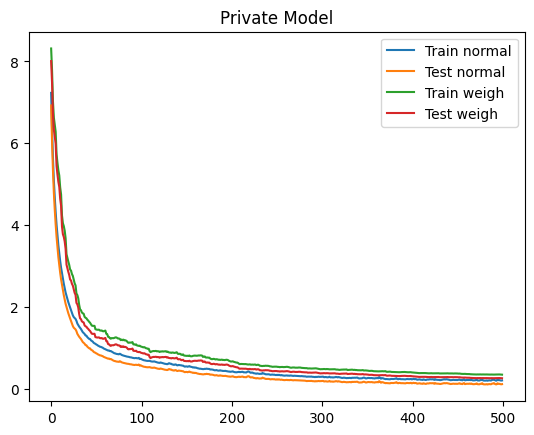

In [86]:
plt.plot(costs_train_private, label="Train normal")
plt.plot(costs_test_private, label="Test normal")
plt.plot(costs_train_private_weigh, label="Train weigh")
plt.plot(costs_test_private_weigh, label="Test weigh")
plt.title("Private Model")
plt.legend()
plt.show()

### Weighted epsilons  implementing theorem 2 : optimal choice of epsilon

In [91]:

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh_2 = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh_2 = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh_2 = np.zeros((total_T, num_agents))
costs_test_private_weigh_2 = np.zeros(total_T)
costs_train_private_weigh_2 = np.zeros(total_T)



# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# on doit calculer grand C = 1 - sigma /(n*Lmax)
# sigma - strongly convex  : correspond à Ql
# Lmax : max Li, les Li sont les constantesblock lipschitz du gradient de Ql
sigma = 0.05                                                                                       # randomly chosen at the moment
Lmax = 20
epsilon_bar = 500
L_0 = 0.25

big_c = 1 - sigma/(num_agents*Lmax)
cube = big_c ** (1/3)
print(cube)
print()

lambdas = np.zeros(num_agents)
agent_choice = np.zeros(total_T)
agent_pre = np.zeros(total_T)
epsilons = np.zeros(total_T)

# we have to know in advance at which iterations each machine wakes up, and we compute our lambdas


for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    agent_choice[i] = j
    res = (cube-1) / ((cube ** total_T)-1) * (cube ** (i+1))
    agent_pre[i] = res
    lambdas[j] += res
    
for i in range(total_T) :
    epsilons[i] = agent_pre[i] * epsilon_bar / lambdas[int(agent_choice[i])]
    

count = 0
sum = 0
epsi_by_agent  = np.zeros(num_agents)
count_by_agent = np.zeros(num_agents)
first = np.zeros(num_agents)
last = np.zeros(num_agents)

for i in range(total_T):    
    if epsi_by_agent[int(agent_choice[i])] == 0:
        first[int(agent_choice[i])] = epsilons[i]
    last[int(agent_choice[i])] = epsilons[i]
    epsi_by_agent[int(agent_choice[i])] +=epsilons[i]
    count_by_agent[int(agent_choice[i])] += 1
    
for i in range(num_agents):
    epsi_by_agent[i] = epsi_by_agent[i] / count_by_agent[i]

rate_epsi = first - last


print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = int(agent_choice[i])
    epsi = epsilons[i]
    thetas_agents_private_weigh_2 = ml.stepForwardPrivate_2(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, L_0, epsi)

    costs_train_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh_2[i, j] = (lr.cost(thetas_agents_private_weigh_2[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh_2[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh_2, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh_2[i]):.4f} , {np.mean(costs_test_agents_private_weigh_2[i]):.4f}) | ({costs_train_private_weigh_2[int(i/10)]:.4f} , {costs_test_private_weigh_2[int(i/10)]:.4f})')

# costs_train_agents_weigh_2 = util.reduce_cost_matrix(costs_train_agents_weigh_2)
# costs_test_agents_weigh_2 = util.reduce_cost_matrix(costs_test_agents_weigh_2)

costs_train_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_train_agents_private_weigh_2)
costs_test_agents_private_weigh_shifted_2 = util.shift_non_zero_costs_to_front(costs_test_agents_private_weigh_2)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted_2, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh_2 = costs_train_private_weigh_2[:T]
costs_test_private_weigh_2 = costs_test_private_weigh_2[:T]

0.9999166597212575

[0.28125 0.0725  0.08    0.01625 0.07125 0.1175  0.07375 0.03625 0.05
 0.20125]
Iter: Agents_Mean       | Total 
  0 : (0.1627 , 0.1334) | (8.3160 , 8.0077)
 50 : (0.0484 , 0.0545) | (1.6881 , 1.4958)
100 : (0.0362 , 0.0426) | (1.2782 , 1.1240)
150 : (0.0320 , 0.0383) | (0.9214 , 0.7899)
200 : (0.0397 , 0.0420) | (0.6931 , 0.5766)
250 : (0.0410 , 0.0443) | (0.5549 , 0.4477)
300 : (0.0265 , 0.0329) | (0.4509 , 0.3501)
350 : (0.0254 , 0.0319) | (0.3997 , 0.3035)
400 : (0.0349 , 0.0384) | (0.3757 , 0.2828)
450 : (0.0238 , 0.0305) | (0.3437 , 0.2538)


In [92]:


print("Agent : Iterations  | epsilon | epsilon_barre")
for i in range(num_agents):
    print(f'{int(i):3} : ({nb_iterations[i]:.4f}) | ({epsilon[i]:.4f}) | ({epsilon[i]*nb_iterations[i]})')

print()
print("Agent : Iterations  | epsilon | epsilon_barre | delta_epsilon ")
for i in range(num_agents):
    print(f'{int(i):3} : ({count_by_agent[i]:.4f}) | ({epsi_by_agent[i]:.4f}) | ({epsi_by_agent[i]*count_by_agent[i]}) | ({rate_epsi[i]:.4f}))')

Agent : Iterations  | epsilon | epsilon_barre
  0 : (1406.2500) | (0.3556) | (500.0)
  1 : (362.5000) | (1.3793) | (500.00000000000006)
  2 : (400.0000) | (1.2500) | (500.0)
  3 : (81.2500) | (6.1538) | (500.0)
  4 : (356.2500) | (1.4035) | (500.0)
  5 : (587.5000) | (0.8511) | (500.0)
  6 : (368.7500) | (1.3559) | (500.0)
  7 : (181.2500) | (2.7586) | (500.00000000000006)
  8 : (250.0000) | (2.0000) | (500.0)
  9 : (1006.2500) | (0.4969) | (500.0)

Agent : Iterations  | epsilon | epsilon_barre | delta_epsilon 
  0 : (1436.0000) | (0.3482) | (500.0000000000008) | (0.1450))
  1 : (350.0000) | (1.4286) | (500.0000000000001) | (0.5965))
  2 : (418.0000) | (1.1962) | (500.0) | (0.5023))
  3 : (71.0000) | (7.0423) | (499.9999999999997) | (2.8018))
  4 : (341.0000) | (1.4663) | (500.00000000000034) | (0.6059))
  5 : (595.0000) | (0.8403) | (499.9999999999997) | (0.3488))
  6 : (380.0000) | (1.3158) | (499.99999999999955) | (0.5381))
  7 : (170.0000) | (2.9412) | (499.99999999999994) | (1.207

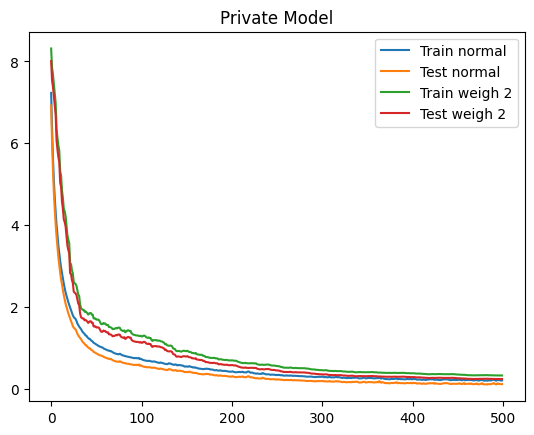

In [93]:
plt.plot(costs_train_private, label="Train normal")
plt.plot(costs_test_private, label="Test normal")
plt.plot(costs_train_private_weigh_2, label="Train weigh 2")
plt.plot(costs_test_private_weigh_2, label="Test weigh 2")
plt.title("Private Model")
plt.legend()
plt.show()